# **Import Library yang dibutuhkan**

In [1]:
# Mengimport Library yang dibutuhkan

import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Import Library yang dibutuhkan

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV


# **Load Dataset**

In [2]:
# Load Dataset

df = pd.read_csv("/content/drive/MyDrive/Dataset Ulasan Google Play/scrapped_data_PlantIdentifier_1.csv")
df.head()

,userName,score,at,content
0,athari azhari,5,2024-07-21 05:09:19,i like it
1,Eli Winarno,5,2024-07-17 01:46:09,Oke
2,Farida Yusuf,5,2024-07-02 12:29:40,Sangat membantu
3,rusman gho,3,2024-07-02 11:32:43,mantap
4,Wartomo Tomo,5,2024-06-28 10:15:26,keren..


In [3]:
# Menampilkan Column Content, Username, dan at.

df = df[['content']]
df

,content
0,i like it
1,Oke
2,Sangat membantu
3,mantap
4,keren..
...,...
832,Sangat membantu bnget aplikasinya.
833,Tulisan nama app bisa dirrubah ke ingglish gak?
834,Bagus..
835,Good


In [4]:
# Memberikan Informasi terkait Dataset yang digunakan

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  837 non-null    object
dtypes: object(1)
memory usage: 6.7+ KB


In [5]:
# Menghasilkan statistik deskriptif data dalam Pandas DataFrame atau Series.

df.describe()

,content
count,837
unique,649
top,Good
freq,25


# **Pre - Processing**


1.   Cleaning Data
2.   Case Folding
3.   Normalization
4.   Stopword
5.   Tokenize
6.   Stemming
7.   Translate
8.   Labeling

# **Cleaning Data & Case Folding**

In [6]:
# Mengetahui jumlah berapa baris dan kolom.

df.shape

(837, 1)

In [7]:
# Menghapus data yang duplicate

df = df.drop_duplicates(subset=['content'])

In [8]:
# Mengecek data yang duplikat

df.duplicated().sum()

0

In [9]:
# Menghapus data yang kosong

df = df.dropna()

In [10]:
# Memastikan tidak ada missing value yang tersisa.

df.isnull().sum()

content    0
dtype: int64

In [11]:
# Mengetahui jumlah berapa baris dan kolom setelahnya

df.shape

(649, 1)

In [12]:
# Fungsi Cleaning Text

def clean_review_text(text): # Membuat Fungsi Cleaning Text
  text = re.sub(r"@[A-Za-z0-9_]+", "", text) # Menghapus Mention
  text = re.sub(r"#\w+", "", text) # Menghapus Hastag
  text = re.sub(r"https?://\S+", "", text) # Menghapus URL

  text = re.sub(r"[^A-Za-z0-9 ]", "", text) # Menghapus Karakter Non Alphanumeric
  text = re.sub(r"\s+", " ", text).strip() # Menghapus Spasi Berlebih
  text = re.sub(r"[0-9]+", "", text)

  return text

In [13]:
# Fungsi Hapus Emoji

def remove_emojis(data): # Membuat Fungsi Hapus Emoji
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [14]:
# Mengaplikasikan Fungsi Cleaning Text, Emoji, dan Case Folding yang sudah dibuat kedalam column 'content'

df['cleaning'] = df['content'].apply(clean_review_text, remove_emojis).str.lower()
df

,content,cleaning
0,i like it,i like it
1,Oke,oke
2,Sangat membantu,sangat membantu
3,mantap,mantap
4,keren..,keren
...,...,...
830,Apk yg sangat berguna,apk yg sangat berguna
831,oke mnatap,oke mnatap
832,Sangat membantu bnget aplikasinya.,sangat membantu bnget aplikasinya
833,Tulisan nama app bisa dirrubah ke ingglish gak?,tulisan nama app bisa dirrubah ke ingglish gak


# **Normalization**

In [15]:
# Normalisasi

norm = {"yg" : "yang",
        "nyri" : "nyari",
        "cvvk" : "",
        "aplk" : "aplikasi",
        "non ton": "nonton",
        "jg" : "juga",
        "jd" : "jadi",
        "klo" : "kalau",
        "gak" : "tidak",
        "woila" : "",
        "kok" : "kenapa",
        "knp" : "kenapa",
        "apk" : "aplikasi",
        "bgt" : "sangat",
        "ntah" : "tidak tahu",
        "mendem" : "tertekan",
        "ngasih" : "memberi",
        "kek" : "seperti",
        "sepertiurangan" : "",
        "pw" : "paswword",
        "gema" : "game",
        "jgn" : "jangan",
        "gajelas" : "tidak jelas",
        "pantes" : "pantas",
        "aelah" : "",
        "geratis" : "gratis",
        "rawwwwwwwwwwwwwrrrrrrrrr" : "",
        "doanload" : "download",
        "ngebag" : "ngebug",
        "ttk" : "Tiktok",
        "elor" : "error",
        "aee kos www www sz" : "",
        "nasdgm" : "",
        "sekalisaya" : "sekali saya",
        "pcr" : "pacar",
        "ttp" : "tetap",
        "007" : "",
        "grafick" : "grafik",
        "bngt" : "banget",
        "sheebal" : "sebal",
        "kemare" : "kemarin",
        "dislek" : "dislike",
        "ngk" : "ngga",
        "mobeli" : "mobile",
        "bguss" : "bagus",
        "yyuy" : "",
        "sakarag" : "sekarang",
        "gbs" : "gabisa",
       }

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['normalization'] = df['cleaning'].apply(lambda x: normalisasi(x))
df

,content,cleaning,normalization
0,i like it,i like it,i like it
1,Oke,oke,oke
2,Sangat membantu,sangat membantu,sangat membantu
3,mantap,mantap,mantap
4,keren..,keren,keren
...,...,...,...
830,Apk yg sangat berguna,apk yg sangat berguna,aplikasi yang sangat berguna
831,oke mnatap,oke mnatap,oke mnatap
832,Sangat membantu bnget aplikasinya.,sangat membantu bnget aplikasinya,sangat membantu bnget aplikasinya
833,Tulisan nama app bisa dirrubah ke ingglish gak?,tulisan nama app bisa dirrubah ke ingglish gak,tulisan nama app bisa dirrubah ke ingglish tidak


# **Stopwords**

In [16]:
# Menginstall Library Sastrawi

!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.4 MB/s eta 0:00:00


In [17]:
# Stopwords

import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = ["dengan", "tidak", "aku", "engkau", "kamu", "beliau", "kalian", "kita", "sini", "situ", "sana",
                   "begini", "bapak", "ibu", "saudara", "tuan", "nyonya", "nona", "siapa", "apa", "mana", "kapan",
                   "bagaimana", "meski", "walaupun", "seandainya", "andai", "jikalau", "kini", "dulu", "sekarang",
                   "tadi", "besok", "lusa", "satu", "tiga", "pertama", "kedua", "ketiga", "sangat", "sekali", "terlalu",
                   "cukup", "lah", "tah", "yang", "nya", "untuk", "dan", "di", "ada", "saya", "ini", "banyak", "bisa", "ga",
                   "udah", "tapi", "sudah", "gak", "lagi", "sama", "lebih"]

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(more_stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopwords(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['stopwords'] = df['normalization'].apply(lambda x: stopwords(x))
df

,content,cleaning,normalization,stopwords
0,i like it,i like it,i like it,i like it
1,Oke,oke,oke,oke
2,Sangat membantu,sangat membantu,sangat membantu,membantu
3,mantap,mantap,mantap,mantap
4,keren..,keren,keren,keren
...,...,...,...,...
830,Apk yg sangat berguna,apk yg sangat berguna,aplikasi yang sangat berguna,aplikasi sangat berguna
831,oke mnatap,oke mnatap,oke mnatap,oke mnatap
832,Sangat membantu bnget aplikasinya.,sangat membantu bnget aplikasinya,sangat membantu bnget aplikasinya,membantu bnget aplikasinya
833,Tulisan nama app bisa dirrubah ke ingglish gak?,tulisan nama app bisa dirrubah ke ingglish gak,tulisan nama app bisa dirrubah ke ingglish tidak,tulisan nama app dirrubah ke ingglish


# **Tokenize**

In [18]:
# Tokenize

df['tokenized'] = df['stopwords'].apply(lambda x:x.split())
df

,content,cleaning,normalization,stopwords,tokenized
0,i like it,i like it,i like it,i like it,"[i, like, it]"
1,Oke,oke,oke,oke,[oke]
2,Sangat membantu,sangat membantu,sangat membantu,membantu,[membantu]
3,mantap,mantap,mantap,mantap,[mantap]
4,keren..,keren,keren,keren,[keren]
...,...,...,...,...,...
830,Apk yg sangat berguna,apk yg sangat berguna,aplikasi yang sangat berguna,aplikasi sangat berguna,"[aplikasi, sangat, berguna]"
831,oke mnatap,oke mnatap,oke mnatap,oke mnatap,"[oke, mnatap]"
832,Sangat membantu bnget aplikasinya.,sangat membantu bnget aplikasinya,sangat membantu bnget aplikasinya,membantu bnget aplikasinya,"[membantu, bnget, aplikasinya]"
833,Tulisan nama app bisa dirrubah ke ingglish gak?,tulisan nama app bisa dirrubah ke ingglish gak,tulisan nama app bisa dirrubah ke ingglish tidak,tulisan nama app dirrubah ke ingglish,"[tulisan, nama, app, dirrubah, ke, ingglish]"


# **Stemming**

In [19]:
# # Steamming

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# def stemming(text_cleaning):
#     factory = StemmerFactory()
#     stemmer = factory.create_stemmer()
#     stemmed_words = [stemmer.stem(w) for w in text_cleaning]
#     return " ".join(stemmed_words)

# df['steamming'] = df['tokenized'].apply(stemming)

# df['steamming'].to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_PlantIdentifier_1.csv', index = False)


In [20]:
df_steamming = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_PlantIdentifier_1.csv', encoding = 'latin1')
df_steamming

,steamming
0,i like it
1,oke
2,bantu
3,mantap
4,keren
...,...
644,apk sangat guna
645,oke mnatap
646,bantu bnget aplikasi
647,tulis nama app dirrubah ingrris


# **Translate**

In [21]:
# # Menginstall Library easynmt

# !pip install -U easynmt

In [22]:
# import pandas as pd
# from easynmt import EasyNMT

In [23]:
# # Load Data Hasil Stemming

# df_steamming = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_steamming_PlantIdentifier_1.csv', encoding = 'latin1')


In [24]:
# # Menentukan Asal & Target Bahasa yang akan diterjemahkan

# source_lang = 'id'  # Replace with the source language of your data
# target_lang = 'en'  # Replace with the target language

In [25]:
# model = EasyNMT('opus-mt')  # You can choose a different model name here

In [26]:
# # Imputing NaN Values

# df_values = df_steamming.fillna(method = 'pad')
# df_values

In [27]:
# # Mengaplikasikan Fungsi Translate yang sudah dibuat kedalam column 'content'

# df_values['steamming_en'] = df_values['steamming'].apply(lambda x: model.translate(x, source_lang=source_lang, target_lang=target_lang))
# df_values.to_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_PlantIdentifier_1.csv')

In [28]:
# Load Dataset Hasil Translate

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_PlantIdentifier_1.csv', index_col=0)
df_values

,steamming,steamming_en
0,i like it,i like it
1,oke,Okay.
2,bantu,Help.
3,mantap,Steady.
4,keren,Cool.
...,...,...
644,apk sangat guna,"fontcolor="" # FFFF00""apkexcellent"
645,oke mnatap,Okay.
646,bantu bnget aplikasi,help set the application
647,tulis nama app dirrubah ingrris,write ingristal change app name


# **Labeling**

In [29]:
# Load Dataset Hasil Translate

df_values = pd.read_csv('/content/drive/MyDrive/Dataset Ulasan Google Play/hasil_terjemahan_PlantIdentifier_1.csv', index_col=0)
df_values


,steamming,steamming_en
0,i like it,i like it
1,oke,Okay.
2,bantu,Help.
3,mantap,Steady.
4,keren,Cool.
...,...,...
644,apk sangat guna,"fontcolor="" # FFFF00""apkexcellent"
645,oke mnatap,Okay.
646,bantu bnget aplikasi,help set the application
647,tulis nama app dirrubah ingrris,write ingristal change app name


In [30]:
# Menginstall Library Text-Blob, Worldcould

!pip install textblob
!pip install wordcloud

In [31]:
# Import Library yang dibutuhkan

from textblob import TextBlob


In [32]:
# Labeling With TextBlob

data_review = list(df_values['steamming_en'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

for i, review in enumerate(data_review):
    analysis = TextBlob(str(review))
    polaritas += analysis.polarity

    if analysis.sentiment.polarity > 0.0:
        total_positif += 1
        status.append("Positif")
    elif analysis.sentiment.polarity == 0.0:
        total_netral += 1
        status.append("Netral")
    else:
        total_negatif += 1
        status.append("Negatif")

    total += 1

print(f"Hasil Analisis Data :\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}")
print(f"\nTotal Data Seluruhnya : {total}")

Hasil Analisis Data :
Positif = 376
Netral = 224
Negatif = 49

Total Data Seluruhnya : 649


In [33]:
# Melihat Status Sentimen

df_values['sentimen'] = status
df_values

,steamming,steamming_en,sentimen
0,i like it,i like it,Netral
1,oke,Okay.,Positif
2,bantu,Help.,Netral
3,mantap,Steady.,Positif
4,keren,Cool.,Positif
...,...,...,...
644,apk sangat guna,"fontcolor="" # FFFF00""apkexcellent",Netral
645,oke mnatap,Okay.,Positif
646,bantu bnget aplikasi,help set the application,Netral
647,tulis nama app dirrubah ingrris,write ingristal change app name,Netral


In [34]:
# Mengimplementasikan Variabel data_final

data_final = df_values
data_final

,steamming,steamming_en,sentimen
0,i like it,i like it,Netral
1,oke,Okay.,Positif
2,bantu,Help.,Netral
3,mantap,Steady.,Positif
4,keren,Cool.,Positif
...,...,...,...
644,apk sangat guna,"fontcolor="" # FFFF00""apkexcellent",Netral
645,oke mnatap,Okay.,Positif
646,bantu bnget aplikasi,help set the application,Netral
647,tulis nama app dirrubah ingrris,write ingristal change app name,Netral


# **Visualization**


1.   Bar Plot
2.   Pie Chart
3.   Wordcloud



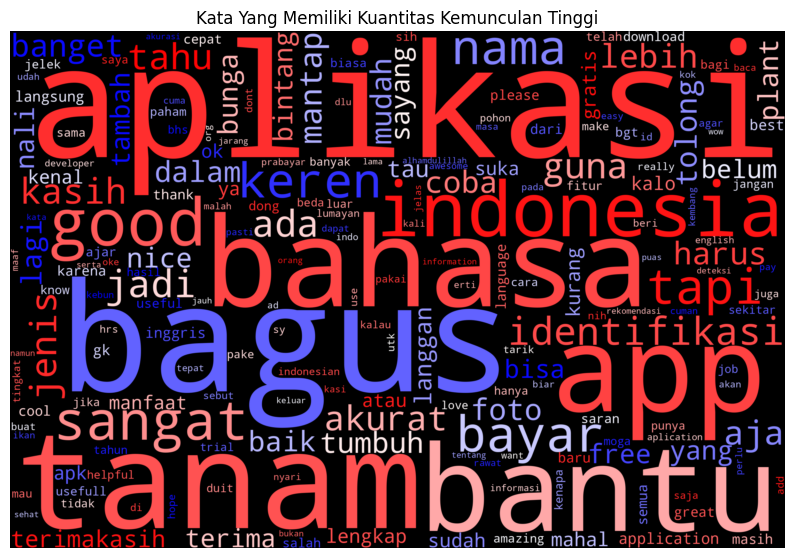

In [35]:
# Visualisasi Kata Yang Memiliki Kuantitas Kemunculan Paling Tinggi

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Kata Yang Memiliki Kuantitas Kemunculan Tinggi')
    plt.axis('off')
    plt.show()

all_words = ' '.join([reviews for reviews in data_final['steamming']])

wordcloud = WordCloud(width=3000,
                      height=2000,
                      random_state=3,
                      background_color='black',
                      colormap='bwr',
                      collocations=False,
                      stopwords=STOPWORDS).generate(all_words)

plot_cloud(wordcloud)


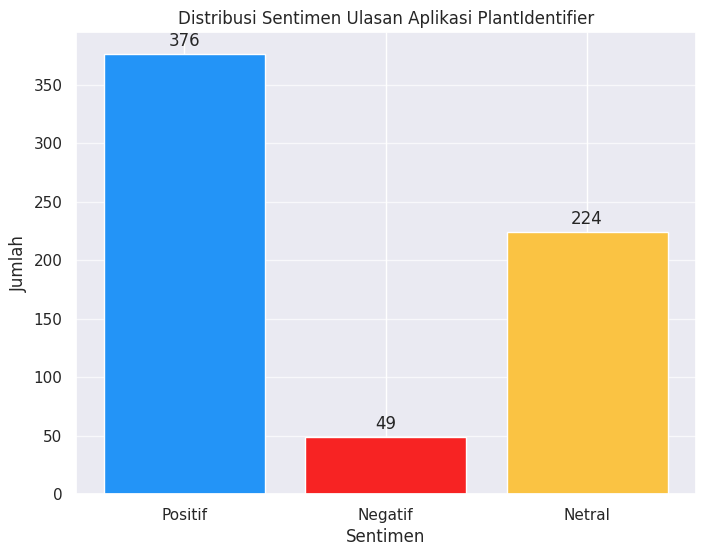

In [36]:
# Visualisasi Distribusi Sentimen Positif , Negatif , Netral Bar Plot

import seaborn as sns

sns.set_theme()

labels = ['Positif', 'Negatif', 'Netral']
counts = [total_positif, total_negatif, total_netral]

def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='-', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

show_bar_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi PlantIdentifier")


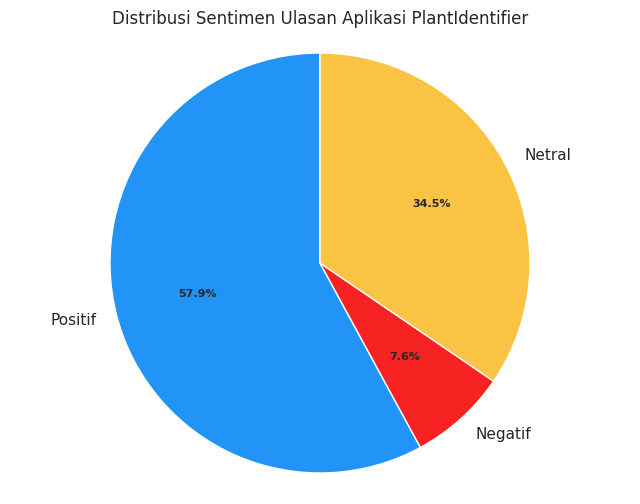

In [37]:
# Visualisasi Distribusi Sentimen Positif , Negatif , Netral Pie Chart

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

labels = ['Positif', 'Negatif', 'Netral']
counts = [total_positif, total_negatif, total_netral]

def show_pie_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Customize colors for each wedge
    colors = ['#2394f7', '#f72323', '#fac343']

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%',
                                      startangle=90, colors=colors)

    # Customize the wedge properties
    ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.setp(autotexts, size=8, weight='bold')

    # Add a title
    ax.set_title(title)

    plt.show()

# Call the pie chart function
show_pie_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi PlantIdentifier")

In [38]:
# Menghapus Sentimen Netral

data_final = data_final[data_final['sentimen'] != 'Netral']
data_final

,steamming,steamming_en,sentimen
1,oke,Okay.,Positif
3,mantap,Steady.,Positif
4,keren,Cool.,Positif
5,bagus banget beneran bantu dalam proses teliti...,It's really good. It helps with careful and ed...,Positif
7,bagus tahu tumbuh yng belum tahu belum,It's good to know grow up and not know yet.,Positif
...,...,...,...
638,bantu moga lebih kembang lagi aplikasi,Help moga more flowers,Positif
639,kalo ada nama dalam bahasa umum misal bahasa i...,if there are names in the common language e.g....,Negatif
642,keep it better,keep it better,Positif
645,oke mnatap,Okay.,Positif


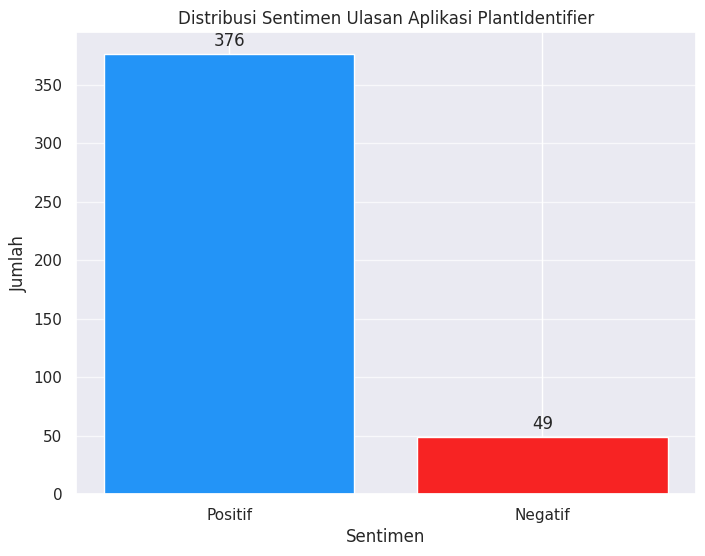

In [39]:
# Visualisasi Distribusi Sentimen Positif & Negatif Bar Plot

import seaborn as sns

sns.set_theme()

labels = ['Positif', 'Negatif']
counts = [total_positif, total_negatif]

def show_bar_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8,6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='-', alpha=0.7)

    ax.set_xlabel('Sentimen')
    ax.set_ylabel('Jumlah')
    ax.set_title(title)

    plt.show()

show_bar_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi PlantIdentifier")


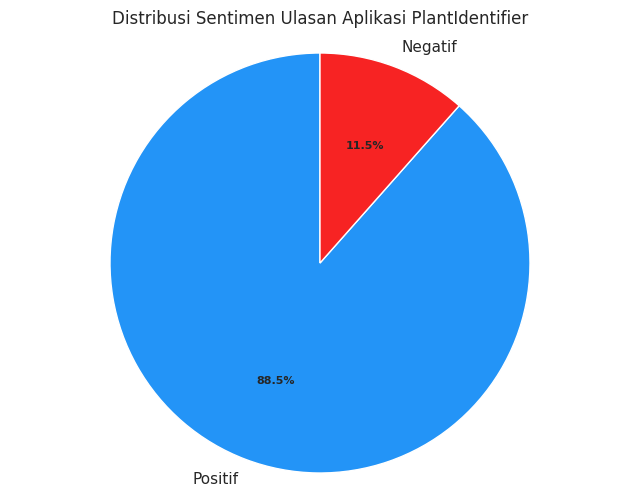

In [40]:
# Visualisasi Distribusi Sentimen Positif & Negatif Bar Pie Chart

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

labels = ['Positif', 'Negatif']
counts = [total_positif, total_negatif]

def show_pie_chart(labels, counts, title):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Customize colors for each wedge
    colors = ['#2394f7', '#f72323', '#fac343']

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(counts, labels=labels, autopct='%1.1f%%',
                                      startangle=90, colors=colors)

    # Customize the wedge properties
    ax.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.setp(autotexts, size=8, weight='bold')

    # Add a title
    ax.set_title(title)

    plt.show()

# Call the pie chart function
show_pie_chart(labels, counts, "Distribusi Sentimen Ulasan Aplikasi PlantIdentifier")

In [41]:
# Replace Data Sentimen

data_final = data_final.replace({'Positif':0, 'Negatif':1})
data_final

,steamming,steamming_en,sentimen
1,oke,Okay.,0
3,mantap,Steady.,0
4,keren,Cool.,0
5,bagus banget beneran bantu dalam proses teliti...,It's really good. It helps with careful and ed...,0
7,bagus tahu tumbuh yng belum tahu belum,It's good to know grow up and not know yet.,0
...,...,...,...
638,bantu moga lebih kembang lagi aplikasi,Help moga more flowers,0
639,kalo ada nama dalam bahasa umum misal bahasa i...,if there are names in the common language e.g....,1
642,keep it better,keep it better,0
645,oke mnatap,Okay.,0


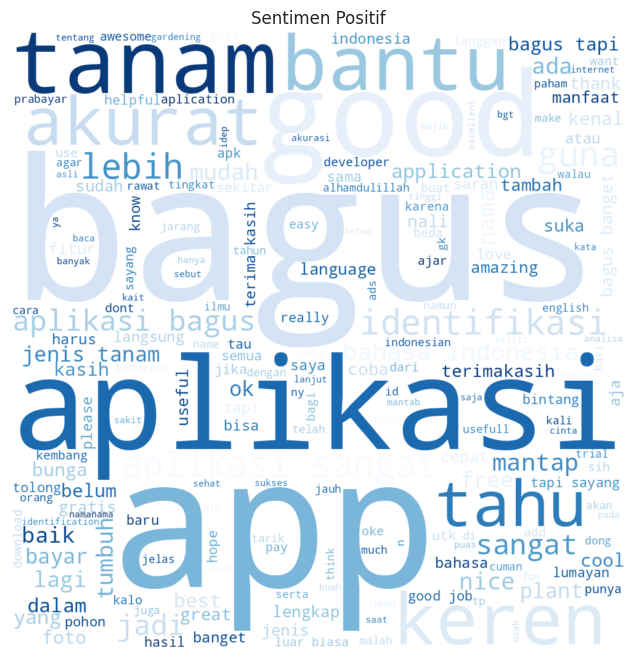

In [42]:
# Visualisasi Wordcould Positif & Negatif

data_positif = data_final[data_final['sentimen'] == 0]
data_negatif = data_final[data_final['sentimen'] == 1]

# Sentimen Positif

all_words = ' '.join([reviews for reviews in data_positif['steamming']])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Positif")
plt.margins(x=0, y=0)
plt.show()

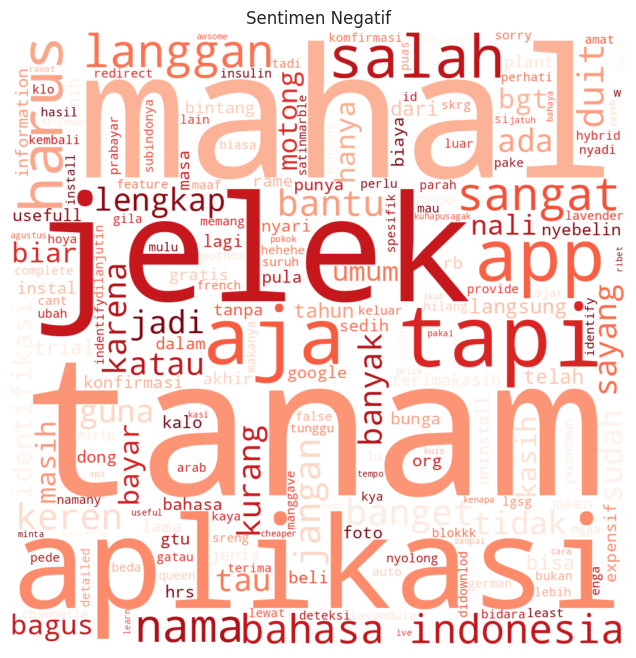

In [43]:
# Sentimen Negatif

all_words = ' '.join([reviews for reviews in data_negatif['steamming']])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Sentimen Negatif")
plt.margins(x=0, y=0)
plt.show()

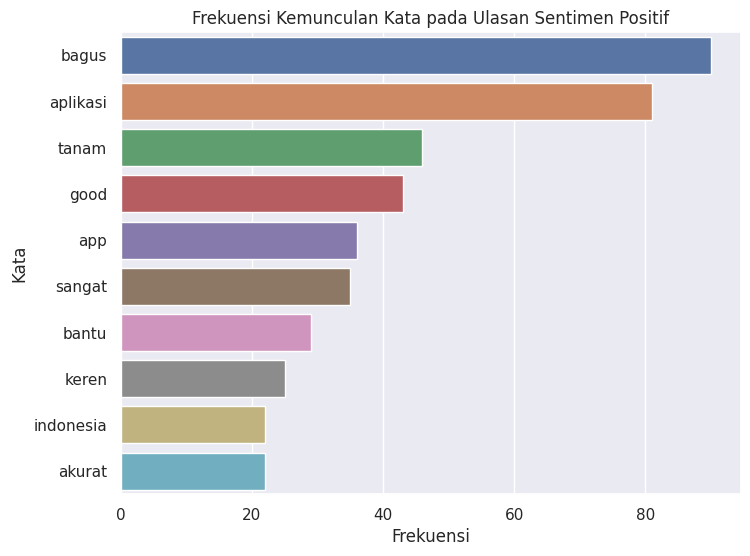

In [44]:
# Frekuensi Kemunculan Kata pada Ulasan Sentimen Positif

# Memfilter ulasan dengan sentimen positif
positive_reviews = data_final[data_final['sentimen'] == 0]['steamming'].tolist()

# Menggunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer(stop_words='english')  # Anda bisa menambahkan stop words lainnya jika perlu
word_counts = vectorizer.fit_transform(positive_reviews)
word_frequencies = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).tolist()[0]))

# Mengubah dictionary menjadi dataframe untuk memudahkan visualisasi
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)

# Membatasi ke N kata yang paling sering muncul
N = 10
top_words_positive = word_freq_df.head(N)

# Membuat bar plot menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='frekuensi', y='kata', hue='kata', legend=False, data=top_words_positive)
plt.title('Frekuensi Kemunculan Kata pada Ulasan Sentimen Positif')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [45]:
# Jumlah detail kata yang sering muncul

print("Jumlah detail kata yang sering muncul pada ulasan sentimen positif : \n")
print(top_words_positive.to_string(index=False))

Jumlah detail kata yang sering muncul pada ulasan sentimen positif : 

     kata  frekuensi
    bagus         90
 aplikasi         81
    tanam         46
     good         43
      app         36
   sangat         35
    bantu         29
    keren         25
indonesia         22
   akurat         22


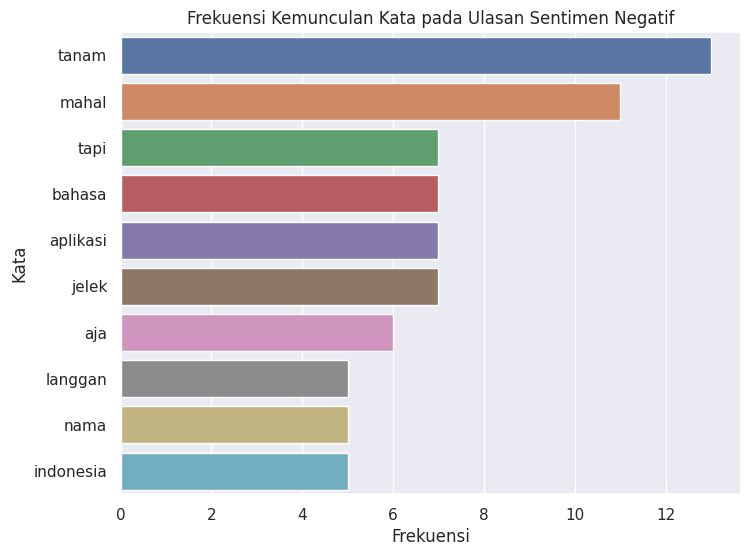

In [46]:
# Frekuensi Kemunculan Kata pada Ulasan Sentimen Negatif

# Memfilter ulasan dengan sentimen positif
negative_reviews = data_final[data_final['sentimen'] == 1]['steamming'].tolist()

# Menggunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer(stop_words='english')  # Anda bisa menambahkan stop words lainnya jika perlu
word_counts = vectorizer.fit_transform(negative_reviews)
word_frequencies = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).tolist()[0]))

# Mengubah dictionary menjadi dataframe untuk memudahkan visualisasi
word_freq_df = pd.DataFrame(word_frequencies.items(), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)

# Membatasi ke N kata yang paling sering muncul
N = 10
top_words_negative = word_freq_df.head(N)

# Membuat bar plot menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='frekuensi', y='kata', hue='kata', legend=False, data=top_words_negative)
plt.title('Frekuensi Kemunculan Kata pada Ulasan Sentimen Negatif')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [47]:
# Jumlah detail kata yang sering muncul

print("Jumlah detail kata yang sering muncul pada ulasan sentimen Negatif : \n")
print(top_words_negative.to_string(index=False))

Jumlah detail kata yang sering muncul pada ulasan sentimen Negatif : 

     kata  frekuensi
    tanam         13
    mahal         11
     tapi          7
   bahasa          7
 aplikasi          7
    jelek          7
      aja          6
  langgan          5
     nama          5
indonesia          5


In [48]:
# Menghitung Jumlah Sentimen Positif, Negatif

data_final['sentimen'].value_counts()

sentimen
0    376
1     49
Name: count, dtype: int64

# **Transormation & Data Preparation**

In [49]:
# Memisahkan data menjadi data latih dan data uji [ Splitting Data ]

X = data_final['steamming']
y = data_final['sentimen']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [50]:
# Menggunakan TF - IDF Vectorizer untuk mengubah teks menjadi fitur numerik [ Text Vectorizer ]

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [51]:
# Melakukan oversampling menggunakan Random Over-Sampling pada data latih

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

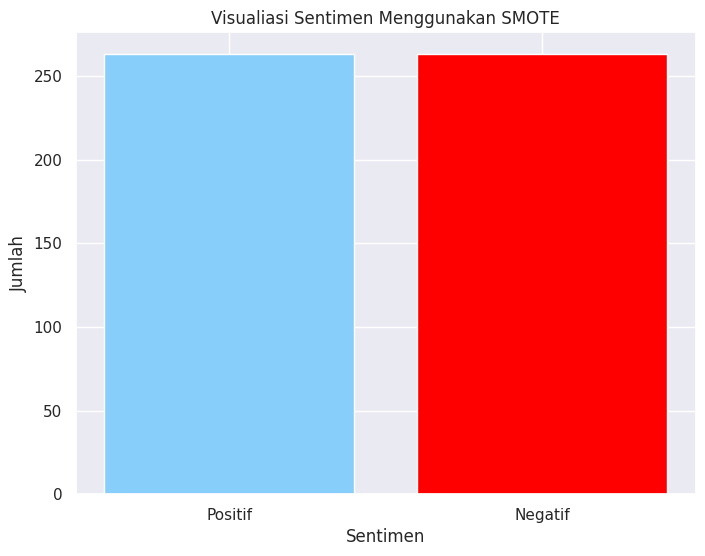

In [52]:
# Visualiasi data hasil resampling menggunakan SMOTE

sentimen_counts = y_train_resampled.value_counts()

plt.figure(figsize = (8, 6))
plt.bar(sentimen_counts.index, sentimen_counts.values, color = ['lightskyblue', 'red'])
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.title('Visualiasi Sentimen Menggunakan SMOTE')
plt.xticks(sentimen_counts.index, ['Positif', 'Negatif'])
plt.show()

# **Data Mining**

In [53]:
# Import Library Warning
import warnings
warnings.filterwarnings('ignore')

In [54]:
X_train_resampled.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# Membangun Model Support vector Machine

for c in [0.01, 0.05, 0.25, 0.5, 0.75, 1]:
  svm = LinearSVC(C=c)
  svm.fit(X_train_resampled, y_train_resampled)
  print('Akurasi untuk c = %s: %s' %(c, accuracy_score(y_test, svm.predict(X_test_vec))))

Akurasi untuk c = 0.01: 0.859375
Akurasi untuk c = 0.05: 0.890625
Akurasi untuk c = 0.25: 0.9140625
Akurasi untuk c = 0.5: 0.9140625
Akurasi untuk c = 0.75: 0.9140625
Akurasi untuk c = 1: 0.9140625


In [56]:
# Menginisialisasi classifier SVM linier,
# membungkusnya dengan model kalibrasi untuk meningkatkan prediksi probabilitasnya,
# dan kemudian melatih model gabungan tersebut pada data pelatihan.

linear_svc = LinearSVC(C = 1.0)
calibrated_svc = CalibratedClassifierCV(linear_svc)
calibrated_svc.fit(X_train_vec, y_train)

CalibratedClassifierCV(estimator=LinearSVC())

# **Interpretation / Evaluation**


1.   Classification Report
2.   Confusion Matrix
3.   Classification Accuracy
4.   Classification Error




In [57]:
# Final Accuracy Score Model

print('Accuracy score model final: %s ' %accuracy_score(y_test, svm.predict(X_test_vec)))

Accuracy score model final: 0.9140625 


In [58]:
# Classification Report

from sklearn.metrics import confusion_matrix

# Evaluasi Model
y_pred = svm.predict(X_test_vec)
print('Akurasi Model Support Vector Machine : {:.4f}' .format(svm.score(X_test_vec, y_test)))

print("\nLaporan Klasifikasi :\n", classification_report(y_test, y_pred))

Akurasi Model Support Vector Machine : 0.9141

Laporan Klasifikasi :
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       113
           1       0.83      0.33      0.48        15

    accuracy                           0.91       128
   macro avg       0.88      0.66      0.71       128
weighted avg       0.91      0.91      0.90       128



In [59]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives (TP) = ', cm[0, 0])

print('\nTrue Negatives (TN) = ', cm[1, 1])

print('\nFalse Positives (FP) = ', cm[0, 1])

print('\nFalse Negatives (FN) = ', cm[1, 0])



print('\nAccuracy = ', accuracy)

Confusion matrix

 [[112   1]
 [ 10   5]]

True Positives (TP) =  112

True Negatives (TN) =  5

False Positives (FP) =  1

False Negatives (FN) =  10

Accuracy =  0.9140625


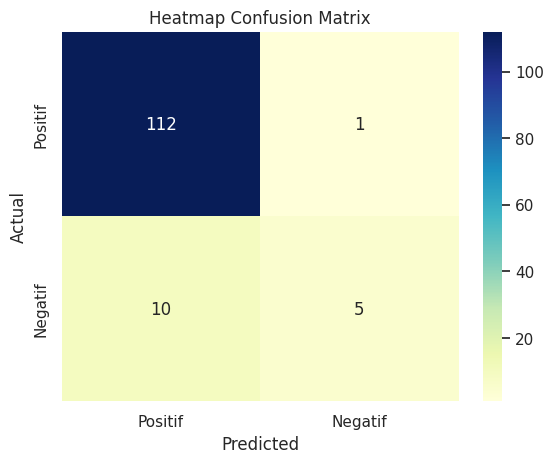

In [60]:
# Visualisasi Heatmap Confusion Matrix

cm_matrix = pd.DataFrame(data=cm, columns=['Positif', 'Negatif'],
                         index=['Positif', 'Negatif'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Heatmap Confusion Matrix')
plt.show()

In [61]:
# Classification Accuracy

TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]


In [62]:
# Classification Accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9141


In [63]:
# Classification Error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.0859


# **Testing**

In [64]:
# Contoh teks baru

new_text = input("\nMasukkan Teks Baru : ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = calibrated_svc.predict(new_text_vec)
predicted_proba = calibrated_svc.predict_proba(new_text_vec)

if predicted_sentimen[0] == 0:
    sentimen_label = "Positif"
    probability = predicted_proba[0][0] * 100
elif predicted_sentimen[0] == 1:
    sentimen_label = "Negatif"
    probability = predicted_proba[0][1] * 100

print("Hasil Analisis Sentimen Untuk Teks Baru:", sentimen_label)
print("Probabilitas: {:.2f}%".format(probability))
print("Probabilitas:", probability, "%")



Masukkan Teks Baru : bagus aplikasi yang membantu, lebih dilengkapi lagi tentang diskripsi dan cara merawatnya
Hasil Analisis Sentimen Untuk Teks Baru: Positif
Probabilitas: 96.02%
Probabilitas: 96.01795451378739 %


In [65]:
# Contoh teks baru

new_text = input("\nMasukkan Teks Baru : ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = calibrated_svc.predict(new_text_vec)
predicted_proba = calibrated_svc.predict_proba(new_text_vec)

if predicted_sentimen[0] == 0:
    sentimen_label = "Positif"
    probability = predicted_proba[0][0] * 100
elif predicted_sentimen[0] == 1:
    sentimen_label = "Negatif"
    probability = predicted_proba[0][1] * 100

print("Hasil Analisis Sentimen Untuk Teks Baru:", sentimen_label)
print("Probabilitas: {:.2f}%".format(probability))
print("Probabilitas:", probability, "%")



Masukkan Teks Baru : Jelek lama sekali mendeteksi nya,di tunggu tidak keluar hasil
Hasil Analisis Sentimen Untuk Teks Baru: Negatif
Probabilitas: 85.94%
Probabilitas: 85.93616445414423 %
